In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import scipy.stats as s
import matplotlib.patches as mpatches
import math
import csv
import os
import opendssdirect as dss
from opendssdirect.utils import run_command
import types
import matplotlib.pyplot as plt
import inspect
import statistics
from itertools import combinations,permutations
import matplotlib.patches as mpatches



In [2]:
m_1 = None
m_2 = None
m_3 = None
m_4 = None
m_5 = None
m_6 = None

In [3]:
def simulatePrediction(dfInput, matrix, useController=True, useAlgo=False,only2=False):
    df = dfInput.copy()
    if not only2:
        convert_matrix = {
            #charging
            matrix[0] : -1,
            #stale
            matrix[1] : 0,
            #discharging
            matrix[2] : 1,
        }
    else:
        convert_matrix = {
        #charging
        matrix[0] : -1,
        #stale
        matrix[1] : 1,
    }
    export_df = pd.DataFrame()
    for day in range(int(len(df)/96)):
        day_start = day
        day_end = day+95

        df.loc[day:day_end, "shops"].to_csv(shops_path,header=False,index=False)
        df.loc[day:day_end, "industrial_park"].to_csv(park_path,header=False,index=False)
        df.loc[day:day_end, "office_building"].to_csv(office_path,header=False,index=False)

        df.loc[day:day_end, "fve"].to_csv(fve_path,header=False,index=False)
        df.loc[day:day_end, "mve"].to_csv(mve_path,header=False,index=False)
        df.loc[day:day_end, "wpg"].to_csv(wpg_path,header=False,index=False)


        clusters = df.loc[day:day_end,"clusters"].values
        clusters_hourly = list()
        for i in range(0,len(clusters),4):
                clusters_hourly.append(statistics.mode(clusters[i:i+4]))
        clusters_hourly = np.array(clusters_hourly)

        clusters_hourly[clusters_hourly == 0] = convert_matrix[0]
        clusters_hourly[clusters_hourly == 1] = convert_matrix[1]
        if not only2:
            clusters_hourly[clusters_hourly == 2] = convert_matrix[2]

        # compile
        x = run_command("Compile microgrid.dss")

        # Loads
        LOADS_ENABLED='Yes'
        dss.run_command('New Load.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98  daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
            name='officeBuilding',
            bus='712',
            daily='officeLoad',
            enabled=LOADS_ENABLED
        ))
        dss.run_command('New Load.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98  daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
            name='industrialPark',
            bus='705',
            daily='industrialParkLoad',
            enabled=LOADS_ENABLED
        ))
        dss.run_command('New Load.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98  daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
            name='shops',
            bus='713',
            daily='shopsLoad',
            enabled=LOADS_ENABLED
        ))

        GENERATORS_ENABLED='Yes'
        dss.run_command('New Generator.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98 kw={kw} daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
            name='fve',
            bus='705',
            daily='fveLoad',
            enabled=GENERATORS_ENABLED,
            kw=1
        ))
        dss.run_command('New Generator.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98 kw={kw} daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
            name='mve',
            bus='701',
            daily='mveLoad',
            enabled=GENERATORS_ENABLED,
            kw=1
        ))
        dss.run_command('New Generator.{name} Bus1={bus} Phases=3 Conn=wye Model=1 kV=0.4  pf=0.98 kw={kw} daily={daily} Vminpu=0.5 Vmaxpu=3 enabled={enabled}'.format(
            name='wpg',
            bus='714',
            daily='wpgLoad',
            enabled=GENERATORS_ENABLED,
            kw=1
        ))

        dss.run_command('new storage.baterry bus=701 kV=0.4 Phases=3 kwRated=100 kWhrated=400 kWhstored=0 vminpu=0.80 vmaxpu=1.20  %reserve=20  %effcharge=100   %effdischarge=100   %IdlingkW=0   enabled=yes')

        dss.run_command('New Monitor.{name}  element=Line.{elementname}  ppolar=no mode=65 enabled={enabled}'.format(
        name='trafo',
        elementname='L1',
        enabled='Yes'
        ))
        dss.run_command('New Monitor.baterry  element=storage.baterry mode=3')
        
        if useController:
            # init battery controll shape
            loadshape_string = str(clusters_hourly).replace(" ", ",").replace(",,", ",")
            x = dss.run_command('''
                New LoadShape.SC_loadshape interval=1 npts=96 mult={shape}
                '''.format(shape=loadshape_string))
            x = dss.run_command('''
            New StorageController.SC element=Line.L1 terminal=1 modedis=loadshape daily=SC_loadshape %rateCharge=100 %reserve=0 eventlog=yes
            ''')
        elif useAlgo:
            dss.run_command('''
            new StorageController.scbattery 
            element=Line.L1  
            Terminal=1 
            Elementlist=[baterry]  
            modedischarge=Peakshave 
            kWTarget=80 
            modeCharge=PeakShaveLow 
            kWTargetlow=0   
            InhibitTime=1')
            ''')
        # dss variables
        dss.run_command('Set controlmode=time')
        dss.run_command('Set mode=daily ')
        dss.run_command('Set stepsize=15m')
        dss.run_command('Set number=96')
        x = dss.run_command('Solve');

        # export data
        trafo_path = dss.run_command('Export monitor object=trafo')
        battery_path = dss.run_command('Export monitor object=baterry')
        trafo_df = pd.read_csv(trafo_path)
        battery_df = pd.read_csv(battery_path)
        day_df = battery_df.copy()
        day_df['kW'] = trafo_df['P1 (kW)'].copy()
        export_df = pd.concat([export_df, day_df], ignore_index=True)

    df['kW'] = export_df['kW'] * 0.001
    df['kWOut'] = export_df['kWOut']
    df['kWIn'] = export_df['kWIn']
    return df

In [4]:
# loadshapes paths
office_path = "../data/consumption/loadshapes/office_building_loadshape_values.csv" 
park_path = "../data/consumption/loadshapes/industrial_park_loadshape_values.csv"
shops_path = "../data/consumption/loadshapes/shops_loadshape_values.csv"
fve_path = "../data/production/loadshapes/FVE_loadshape_values.csv"
mve_path = "../data/production/loadshapes/MVE_loadshape_values.csv"
wpg_path = "../data/production/loadshapes/WPG_loadshape_values.csv"

#clustering_Kmeans2
#clustering_Kmeans3
#clustering_KmeansHuang2
#clustering_KmeansHuang3

# Kmeans 3

In [5]:
%%time

df = pd.read_csv("../data/clustering_Kmeans3.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')
# for per in permutations([1,0,2]):
#     df = simulatePrediction(df, per)    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     print(per,df['kWIn'].sum(),df['kWOut'].sum(), df[df['kW'] >0]['kW'].sum())
#     fig.set_size_inches(18.5, 5)
#     ax1.plot(df['kWOut'])
#     ax2.plot(df['kWIn'])
#     plt.show()

CPU times: user 61.1 ms, sys: 10.6 ms, total: 71.7 ms
Wall time: 71.2 ms


Spotreba LSTM+KNN 104.48160892
Spotreba PeakeShave 109.32939021509252
Spotreba BASE 126.80447181000001
Cost LSTM+KNN 2503.7855992996
Cost PeakeShave 2691.0437806504306
Cost BASE 3110.0390938644005


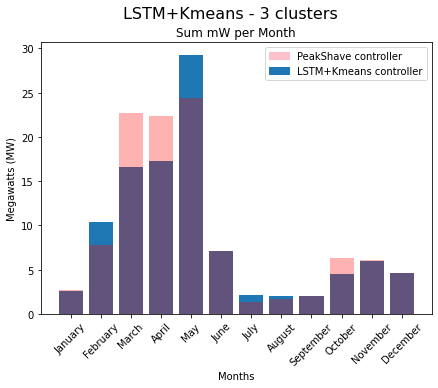

In [6]:
pred = simulatePrediction(df, (1, 0, 2))
pred = pred[pred['kW'] > 0]
base = simulatePrediction(df, (1, 0, 2)  ,useController=False,useAlgo=True)
base = base[base['kW'] > 0]
base_noAlgo = simulatePrediction(df, (1, 0, 2) ,useController=False,useAlgo=False)
base_noAlgo = base_noAlgo[base_noAlgo['kW'] > 0]


print("Spotreba LSTM+KNN",pred[pred['kW'] >0]['kW'].sum())
print("Spotreba PeakeShave",base[base['kW'] >0]['kW'].sum())
print("Spotreba BASE",base_noAlgo[base_noAlgo['kW'] >0]['kW'].sum()) 

print("Cost LSTM+KNN",np.sum(pred[pred['kW'] >0]['kW'] * pred[pred['kW'] >0]['price'] ))
print("Cost PeakeShave",np.sum(base[base['kW'] >0]['kW'] * base[base['kW'] >0]['price']))
print("Cost BASE",np.sum(base_noAlgo[base_noAlgo['kW'] >0]['kW'] * base_noAlgo[base_noAlgo['kW'] >0]['price']))

monthly = pred.copy()
monthly.index = monthly.date
monthly = monthly.resample("1M").sum()
monthly['monthName'] = monthly.index.month_name()

baseMonthly = base.copy()
baseMonthly.index = baseMonthly.date
baseMonthly = baseMonthly.resample("1M").sum()
baseMonthly['monthName'] = baseMonthly.index.month_name()

monthlyAvgPrice = pred.copy()
monthlyAvgPrice.index = monthlyAvgPrice.date
monthlyAvgPrice = monthlyAvgPrice.resample("1M").mean()

m_3 = monthly

fig, ax1 = plt.subplots(1, 1)
blue_patch = mpatches.Patch(color='tab:blue', label='LSTM+Kmeans controller')
red_patch = mpatches.Patch(color='pink', label='PeakShave controller')
fig.set_size_inches(7, 5)

ax1.set_title("Sum mW per Month")
ax1.bar(monthly['monthName'],monthly['kW'],color="tab:blue")
ax1.bar(baseMonthly['monthName'],baseMonthly['kW'],color="red",alpha=0.3)
ax1.set_xlabel("Months")
ax1.set_ylabel("Megawatts (MW)")
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax1.legend(handles=[red_patch,blue_patch])

# ax2.set_title("Energy cost per Month")
# ax2.plot(monthly['monthName'],monthly['kW']*monthlyAvgPrice['price'],color="tab:blue")
# ax2.plot(baseMonthly['monthName'],baseMonthly['kW']*monthlyAvgPrice['price'],color="red",alpha=0.3)
# ax2.set_xlabel("Months")
# ax2.set_ylabel("Megawatts (MW)")
# plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
# ax2.legend(handles=[red_patch,blue_patch])
fig.suptitle("LSTM+Kmeans - 3 clusters",fontsize=16)
plt.savefig('LSTM+Kmeans - 3 clusters.png')
plt.show()

# PeakShave

Spotreba PeakeShave 109.32939021509252
Spotreba BASE 126.80447181000001
Cost PeakeShave 2691.0437806504306
Cost BASE 3110.0390938644005


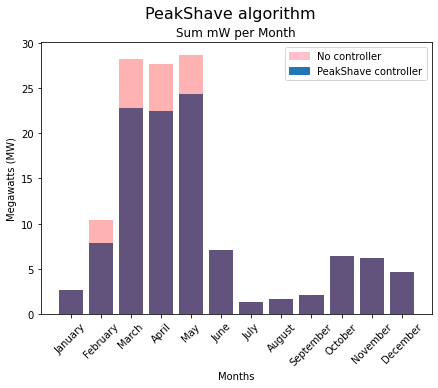

In [7]:

pred = simulatePrediction(df, (1, 0, 2)  ,useController=False,useAlgo=True)
pred = base[base['kW'] > 0]
base = simulatePrediction(df, (1, 0, 2) ,useController=False,useAlgo=False)
base = base_noAlgo[base_noAlgo['kW'] > 0]


print("Spotreba PeakeShave",pred[pred['kW'] >0]['kW'].sum())
print("Spotreba BASE",base[base['kW'] >0]['kW'].sum())

print("Cost PeakeShave",np.sum(pred[pred['kW'] >0]['kW'] * pred[pred['kW'] >0]['price'] ))
print("Cost BASE",np.sum(base[base['kW'] >0]['kW'] * base[base['kW'] >0]['price']))

monthly = pred.copy()
monthly.index = monthly.date
monthly = monthly.resample("1M").sum()
monthly['monthName'] = monthly.index.month_name()

baseMonthly = base.copy()
baseMonthly.index = baseMonthly.date
baseMonthly = baseMonthly.resample("1M").sum()
baseMonthly['monthName'] = baseMonthly.index.month_name()

monthlyAvgPrice = pred.copy()
monthlyAvgPrice.index = monthlyAvgPrice.date
monthlyAvgPrice = monthlyAvgPrice.resample("1M").mean()

m_1 = monthly
m_2 = baseMonthly


fig, ax1 = plt.subplots(1, 1)
blue_patch = mpatches.Patch(color='tab:blue', label='PeakShave controller')
red_patch = mpatches.Patch(color='pink', label='No controller')
fig.set_size_inches(7, 5)

ax1.set_title("Sum mW per Month")
ax1.bar(monthly['monthName'],monthly['kW'],color="tab:blue")
ax1.bar(baseMonthly['monthName'],baseMonthly['kW'],color="red",alpha=0.3)
ax1.set_xlabel("Months")
ax1.set_ylabel("Megawatts (MW)")
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax1.legend(handles=[red_patch,blue_patch])

# ax2.set_title("Energy cost per Month")
# ax2.bar(monthly['monthName'],monthly['kW']*monthlyAvgPrice['price'],color="tab:blue")
# ax2.bar(baseMonthly['monthName'],baseMonthly['kW']*monthlyAvgPrice['price'],color="red",alpha=0.3)
# ax2.set_xlabel("Months")
# ax2.set_ylabel("Megawatts (MW)")
# plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
# ax2.legend(handles=[red_patch,blue_patch])
fig.suptitle("PeakShave algorithm",fontsize=16)
plt.savefig('PeakShave algorithm.png')
plt.show()

# Kmeans 2

In [8]:
%%time

df = pd.read_csv("../data/clustering_Kmeans2.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')
# for per in permutations([1,0,1,0],3):
#     print(per)
#     df = simulatePrediction(df, per)    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     print(per,df['kWIn'].sum(),df['kWOut'].sum(), df[df['kW'] >0]['kW'].sum())
#     fig.set_size_inches(18.5, 5)
#     ax1.plot(df['kWOut'])
#     ax2.plot(df['kWIn'])
#     plt.show()
    
#(0, 2, 1)

CPU times: user 212 ms, sys: 11.5 ms, total: 224 ms
Wall time: 75.5 ms


Spotreba LSTM+KNN 215.02223215
Spotreba PeakeShave 109.32939021509252
Spotreba BASE 126.80447181000001
Cost LSTM+KNN 4898.1407577948
Cost PeakeShave 2691.0437806504306
Cost BASE 3110.0390938644005


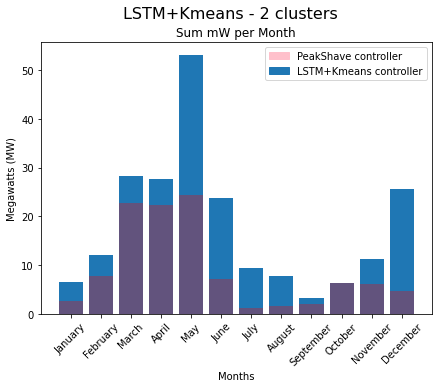

In [9]:
pred = simulatePrediction(df, (0, 1, 0),only2=True)
pred = pred[pred['kW'] > 0]
base = simulatePrediction(df, (0, 1, 0) ,useController=False,useAlgo=True,only2=True)
base = base[base['kW'] > 0]
base_noAlgo = simulatePrediction(df, (0, 1, 0),useController=False,useAlgo=False,only2=True)
base_noAlgo = base_noAlgo[base_noAlgo['kW'] > 0]


print("Spotreba LSTM+KNN",pred[pred['kW'] >0]['kW'].sum())
print("Spotreba PeakeShave",base[base['kW'] >0]['kW'].sum())
print("Spotreba BASE",base_noAlgo[base_noAlgo['kW'] >0]['kW'].sum()) 

print("Cost LSTM+KNN",np.sum(pred[pred['kW'] >0]['kW'] * pred[pred['kW'] >0]['price'] ))
print("Cost PeakeShave",np.sum(base[base['kW'] >0]['kW'] * base[base['kW'] >0]['price']))
print("Cost BASE",np.sum(base_noAlgo[base_noAlgo['kW'] >0]['kW'] * base_noAlgo[base_noAlgo['kW'] >0]['price']))

monthly = pred.copy()
monthly.index = monthly.date
monthly = monthly.resample("1M").sum()
monthly['monthName'] = monthly.index.month_name()

baseMonthly = base.copy()
baseMonthly.index = baseMonthly.date
baseMonthly = baseMonthly.resample("1M").sum()
baseMonthly['monthName'] = baseMonthly.index.month_name()

monthlyAvgPrice = pred.copy()
monthlyAvgPrice.index = monthlyAvgPrice.date
monthlyAvgPrice = monthlyAvgPrice.resample("1M").mean()

m_4 = monthly

fig, ax1 = plt.subplots(1, 1)
blue_patch = mpatches.Patch(color='tab:blue', label='LSTM+Kmeans controller')
red_patch = mpatches.Patch(color='pink', label='PeakShave controller')
fig.set_size_inches(7, 5)

ax1.set_title("Sum mW per Month")
ax1.bar(monthly['monthName'],monthly['kW'],color="tab:blue")
ax1.bar(baseMonthly['monthName'],baseMonthly['kW'],color="red",alpha=0.3)
ax1.set_xlabel("Months")
ax1.set_ylabel("Megawatts (MW)")
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax1.legend(handles=[red_patch,blue_patch])

# ax2.set_title("Energy cost per Month")
# ax2.bar(monthly['monthName'],monthly['kW']*monthlyAvgPrice['price'],color="tab:blue")
# ax2.bar(baseMonthly['monthName'],baseMonthly['kW']*monthlyAvgPrice['price'],color="red",alpha=0.3)
# ax2.set_xlabel("Months")
# ax2.set_ylabel("Megawatts (MW)")
# plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
# ax2.legend(handles=[red_patch,blue_patch])
fig.suptitle("LSTM+Kmeans - 2 clusters",fontsize=16)
plt.savefig('LSTM+Kmeans - 2 clusters.png')
plt.show()

# AGLO 2

In [10]:
%%time

df = pd.read_csv("../data/clustering_aglo2.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')
# for per in permutations([1,0,1,0],3):
#     df = simulatePrediction(df, per)    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     print(per,df['kWIn'].sum(),df['kWOut'].sum(), df[df['kW'] >0]['kW'].sum())
#     fig.set_size_inches(18.5, 5)
#     ax1.plot(df['kWOut'])
#     ax2.plot(df['kWIn'])
#     plt.show()

CPU times: user 207 ms, sys: 13.5 ms, total: 220 ms
Wall time: 73.9 ms


Spotreba LSTM+KNN 116.27758776000002
Spotreba PeakeShave 109.32939021509252
Spotreba BASE 126.80447181000001
Cost LSTM+KNN 2857.3307056684002
Cost PeakeShave 2691.0437806504306
Cost BASE 3110.0390938644005


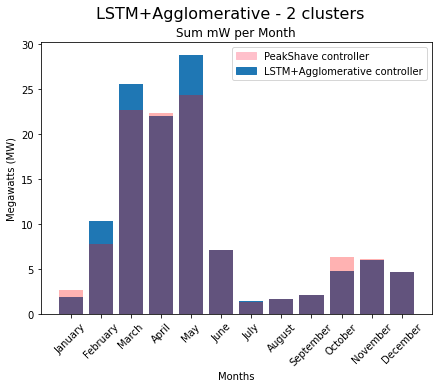

In [11]:
pred = simulatePrediction(df, (0, 1, 0),only2=True )
pred = pred[pred['kW'] > 0]
base = simulatePrediction(df, (0, 1, 0)  ,useController=False,useAlgo=True,only2=True)
base = base[base['kW'] > 0]
base_noAlgo = simulatePrediction(df, (0, 1, 0) ,useController=False,useAlgo=False,only2=True)
base_noAlgo = base_noAlgo[base_noAlgo['kW'] > 0]


print("Spotreba LSTM+KNN",pred[pred['kW'] >0]['kW'].sum())
print("Spotreba PeakeShave",base[base['kW'] >0]['kW'].sum())
print("Spotreba BASE",base_noAlgo[base_noAlgo['kW'] >0]['kW'].sum()) 

print("Cost LSTM+KNN",np.sum(pred[pred['kW'] >0]['kW'] * pred[pred['kW'] >0]['price'] ))
print("Cost PeakeShave",np.sum(base[base['kW'] >0]['kW'] * base[base['kW'] >0]['price']))
print("Cost BASE",np.sum(base_noAlgo[base_noAlgo['kW'] >0]['kW'] * base_noAlgo[base_noAlgo['kW'] >0]['price']))

monthly = pred.copy()
monthly.index = monthly.date
monthly = monthly.resample("1M").sum()
monthly['monthName'] = monthly.index.month_name()

baseMonthly = base.copy()
baseMonthly.index = baseMonthly.date
baseMonthly = baseMonthly.resample("1M").sum()
baseMonthly['monthName'] = baseMonthly.index.month_name()

monthlyAvgPrice = pred.copy()
monthlyAvgPrice.index = monthlyAvgPrice.date
monthlyAvgPrice = monthlyAvgPrice.resample("1M").mean()

m_5 = monthly

fig, ax1 = plt.subplots(1, 1)
blue_patch = mpatches.Patch(color='tab:blue', label='LSTM+Agglomerative controller')
red_patch = mpatches.Patch(color='pink', label='PeakShave controller')
fig.set_size_inches(7, 5)

ax1.set_title("Sum mW per Month")
ax1.bar(monthly['monthName'],monthly['kW'],color="tab:blue")
ax1.bar(baseMonthly['monthName'],baseMonthly['kW'],color="red",alpha=0.3)
ax1.set_xlabel("Months")
ax1.set_ylabel("Megawatts (MW)")
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax1.legend(handles=[red_patch,blue_patch])

# ax2.set_title("Energy cost per Month")
# ax2.bar(monthly['monthName'],monthly['kW']*monthlyAvgPrice['price'],color="tab:blue")
# ax2.bar(baseMonthly['monthName'],baseMonthly['kW']*monthlyAvgPrice['price'],color="red",alpha=0.3)
# ax2.set_xlabel("Months")
# ax2.set_ylabel("Megawatts (MW)")
# plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
# ax2.legend(handles=[red_patch,blue_patch])

fig.suptitle("LSTM+Agglomerative - 2 clusters",fontsize=16)
plt.savefig('LSTM+Agglomerative - 2 clusters.png')

plt.show()

# AGLO 3

In [12]:
%%time

df = pd.read_csv("../data/clustering_aglo3.csv")
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d %H:%M')
# for per in permutations([1,0,2]):
#     df = simulatePrediction(df, per)    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     print(per,df['kWIn'].sum(),df['kWOut'].sum(), df[df['kW'] >0]['kW'].sum())
#     fig.set_size_inches(18.5, 5)
#     ax1.plot(df['kWOut'])
#     ax2.plot(df['kWIn'])
#     plt.show()

CPU times: user 202 ms, sys: 13 ms, total: 215 ms
Wall time: 71.8 ms


Spotreba LSTM+KNN 105.09327967000002
Spotreba PeakeShave 109.32939021509252
Spotreba BASE 126.80447181000001
Cost LSTM+KNN 2533.0081273845
Cost PeakeShave 2691.0437806504306
Cost BASE 3110.0390938644005


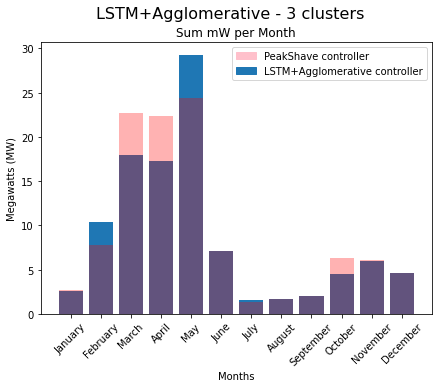

In [13]:
pred = simulatePrediction(df, (2, 0, 1))
pred = pred[pred['kW'] > 0]
base = simulatePrediction(df,(2, 0, 1)  ,useController=False,useAlgo=True)
base = base[base['kW'] > 0]
base_noAlgo = simulatePrediction(df, (2, 0, 1) ,useController=False,useAlgo=False)
base_noAlgo = base_noAlgo[base_noAlgo['kW'] > 0]


print("Spotreba LSTM+KNN",pred[pred['kW'] >0]['kW'].sum())
print("Spotreba PeakeShave",base[base['kW'] >0]['kW'].sum())
print("Spotreba BASE",base_noAlgo[base_noAlgo['kW'] >0]['kW'].sum()) 

print("Cost LSTM+KNN",np.sum(pred[pred['kW'] >0]['kW'] * pred[pred['kW'] >0]['price'] ))
print("Cost PeakeShave",np.sum(base[base['kW'] >0]['kW'] * base[base['kW'] >0]['price']))
print("Cost BASE",np.sum(base_noAlgo[base_noAlgo['kW'] >0]['kW'] * base_noAlgo[base_noAlgo['kW'] >0]['price']))

monthly = pred.copy()
monthly.index = monthly.date
monthly = monthly.resample("1M").sum()
monthly['monthName'] = monthly.index.month_name()

baseMonthly = base.copy()
baseMonthly.index = baseMonthly.date
baseMonthly = baseMonthly.resample("1M").sum()
baseMonthly['monthName'] = baseMonthly.index.month_name()

monthlyAvgPrice = pred.copy()
monthlyAvgPrice.index = monthlyAvgPrice.date
monthlyAvgPrice = monthlyAvgPrice.resample("1M").mean()

m_6 = monthly

fig, ax1 = plt.subplots(1, 1)
blue_patch = mpatches.Patch(color='tab:blue', label='LSTM+Agglomerative controller')
red_patch = mpatches.Patch(color='pink', label='PeakShave controller')
fig.set_size_inches(7, 5)

ax1.set_title("Sum mW per Month")
ax1.bar(monthly['monthName'],monthly['kW'],color="tab:blue")
ax1.bar(baseMonthly['monthName'],baseMonthly['kW'],color="red",alpha=0.3)
ax1.set_xlabel("Months")
ax1.set_ylabel("Megawatts (MW)")
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

ax1.legend(handles=[red_patch,blue_patch])

# ax2.set_title("Energy cost per Month")
# ax2.bar(monthly['monthName'],monthly['kW']*monthlyAvgPrice['price'],color="tab:blue")
# ax2.bar(baseMonthly['monthName'],baseMonthly['kW']*monthlyAvgPrice['price'],color="red",alpha=0.3)
# ax2.set_xlabel("Months")
# ax2.set_ylabel("Megawatts (MW)")
# plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
# ax2.legend(handles=[red_patch,blue_patch])

fig.suptitle("LSTM+Agglomerative - 3 clusters",fontsize=16)
plt.savefig('LSTM+Agglomerative - 3 clusters.png')

plt.show()

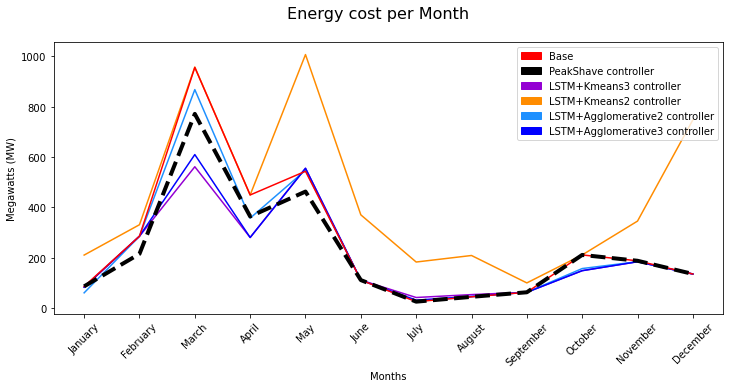

In [63]:
fig, ax2 = plt.subplots(1, 1)
black_patch = mpatches.Patch(color='red', label='Base')
red_patch = mpatches.Patch(color='black', label='PeakShave controller')
blue_patch = mpatches.Patch(color='darkviolet', label='LSTM+Kmeans3 controller')
green_patch = mpatches.Patch(color='darkorange', label='LSTM+Kmeans2 controller')
yellow_patch = mpatches.Patch(color='dodgerblue', label='LSTM+Agglomerative2 controller')
brown_patch = mpatches.Patch(color='blue', label='LSTM+Agglomerative3 controller')

fig.set_size_inches(12, 5)

ax2.set_title("")


ax2.plot(m_3['monthName'],m_3['kW']*monthlyAvgPrice['price'],color="darkviolet",alpha=1)
ax2.plot(m_4['monthName'],m_4['kW']*monthlyAvgPrice['price'],color="darkorange",alpha=1)
ax2.plot(m_5['monthName'],m_5['kW']*monthlyAvgPrice['price'],color="dodgerblue",alpha=1)
ax2.plot(m_6['monthName'],m_6['kW']*monthlyAvgPrice['price'],color="blue",alpha=1)
ax2.plot(m_2['monthName'],m_2['kW']*monthlyAvgPrice['price'],color="red")
ax2.plot(m_1['monthName'],m_1['kW']*monthlyAvgPrice['price'],'--',color="black",alpha=1,linewidth=4)
ax2.set_xlabel("Months")
ax2.set_ylabel("Megawatts (MW)")
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
ax2.legend(handles=[black_patch,red_patch,blue_patch,green_patch,yellow_patch,brown_patch])

ax1.legend(handles=[red_patch,blue_patch])

fig.suptitle("Energy cost per Month",fontsize=16)
plt.savefig('Energy cost per Month.png')